In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra.
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
# More imports

import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the data to a dataframe

heart_failure = pd.read_csv("/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv")

# Display the first 5 rows

heart_failure.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
# Display information about the dataset

heart_failure.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Alright, this dataset consists of 299 rows and 13 columns, with only numerically valued entries. Furthermore, there don't appear to be any missing values that we'll need to address

In [4]:
# Obtain a basic statistical description for the dataset

heart_failure.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


Based off of the standard deviation, $75^{\text{th}}-$percentile, and the maximum value, the following variables have outliers that we will need to address:

1. `creatinine_phosphokinase`
2. `ejection_fraction`
3. `platelets`
4. `serum_creatinine`

There are two possible treatments: winsorization or removal by z-score. For sake of completeness of the dataset, we will opt to winsorize the data since it will limit the extreme values.

In [5]:
# Winsorize the aforementioned variables

from scipy.stats.mstats import winsorize

# Make a copy of the dataframe to apply modifications to 

heart = heart_failure.copy()

# Apply one-way winsorization to the either the 90th or 95th percentile
heart['winsorized_creatinine_phosphokinase'] = winsorize(heart['creatinine_phosphokinase'], [0, 0.1])
heart['winsorized_ejection_fraction'] = winsorize(heart['ejection_fraction'], [0, 0.05])
heart['winsorized_platelets'] = winsorize(heart['platelets'], [0, 0.1])
heart['winsorized_serum_creatinine'] = winsorize(heart['serum_creatinine'], [0, 0.1])

In [6]:
# Check for outliers in the winsorized variables
heart[['winsorized_creatinine_phosphokinase', 'winsorized_ejection_fraction', 
       'winsorized_platelets', 'winsorized_serum_creatinine']].describe()

,winsorized_creatinine_phosphokinase,winsorized_ejection_fraction,winsorized_platelets,winsorized_serum_creatinine
count,299.000000,299.000000,299.000000,299.000000
mean,417.498328,37.953177,254675.755017,1.229666
std,370.748973,11.511789,74911.468807,0.430112
min,23.000000,14.000000,25100.000000,0.500000
25%,116.500000,30.000000,212500.000000,0.900000
50%,250.000000,38.000000,262000.000000,1.100000
75%,582.000000,45.000000,303500.000000,1.400000
max,1211.000000,60.000000,377000.000000,2.100000


This is much more workable than previously, so we can proceed further to the feature engineering phase. First, we'll examine the number of unique entries per variable to get a better sense of the dataset.


In [7]:
# Compute the number of unique values for each variable

for column in heart.columns.drop(['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine']):
    
    print("Number of unique values for {}: ".format(column), heart[column].nunique())

Number of unique values for age:  47
Number of unique values for anaemia:  2
Number of unique values for diabetes:  2
Number of unique values for high_blood_pressure:  2
Number of unique values for serum_sodium:  27
Number of unique values for sex:  2
Number of unique values for smoking:  2
Number of unique values for time:  148
Number of unique values for DEATH_EVENT:  2
Number of unique values for winsorized_creatinine_phosphokinase:  179
Number of unique values for winsorized_ejection_fraction:  13
Number of unique values for winsorized_platelets:  152
Number of unique values for winsorized_serum_creatinine:  20


The following variables are binary: `anaemia`, `diabetes`, `high_blood_pressure`, `sex`,`smoking`, and our target variable `DEATH_EVENT`. This implies that we will be utilizing classification models to make predictions. In particular, we will most likely utilize support vector machines and boosting models. There is a possibility of training a random forest classifier, although this would require additional feature engineering to convert the continuous variables into a suitable form for the random forest classifier.

In [8]:
# Check the dataset for class imbalance (or balance)

heart['DEATH_EVENT'].value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

As the above demonstrates, the dataset exhibits class imbalance, which we will need to address. There are two approaches we can utilize:

1. We oversample the minority class by creating more synthetic data (for the minority class) to match the majority class

2. We undersample the majority class by removing data from the majority class to match the minority class

Of the two approaches, we will opt for the former, as our dataset is relatively small; removal of data may affect the performance of any model we build

In [9]:
# Oversample the minority class

from sklearn.utils import resample

Ones = heart[heart.DEATH_EVENT == 1]
Zeroes = heart[heart.DEATH_EVENT == 0]

Ones_upsample = resample(Ones, replace = True,
                          n_samples = len(Zeroes),
                          random_state = 31)

heart = pd.concat([Zeroes, Ones_upsample])

In [10]:
# Re-examine the `DEATH_EVENTS` column
heart.DEATH_EVENT.value_counts()

0    203
1    203
Name: DEATH_EVENT, dtype: int64

Now the number of zero and one class equal. We can now train our classification models, compare them to select the most accurate base model, and then tune that model's hyperparameters to increase accuracy and hopefully minimize false negatives as this is a heart failure classification (and risk prediction) problem

In [11]:
# Import sklearn models and performance metrics

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse

from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Drop the original columns that we winsorized previously

heart = heart.drop(['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine'], axis = 1)

The first model we'll train is a K Nearest-Neighbors model, but first, we must split the data into training and test sets.

In [12]:
# Split the data into training and test sets, with a test-set size of 30 percent

X = heart.drop('DEATH_EVENT', axis = 1)
Y = heart.DEATH_EVENT

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 131)

In [13]:
# Fit the model 
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

# Make predictions with the model
y_pred_knn = knn.predict(X_test)

# Print accuracy, precision, and recall scores for the model 
acc_knn = accuracy_score(y_test, y_pred_knn)
pre_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
print(" Accuracy score: {} \n".format(acc_knn), 
      "Precision score: {} \n".format(pre_knn),
      "Recall score: {}".format(recall_knn))

 Accuracy score: 0.5163934426229508 
 Precision score: 0.5625 
 Recall score: 0.5373134328358209


In [14]:
# Print a confusion matrix for the above model
print(confusion_matrix(y_test, y_pred_knn))

[[27 28]
 [31 36]]


This isn't necessarily a great model, but we have a baseline that we can compare to other models going forward. Next, we will build a baseline Random Forest Classifier.

In [15]:
# Instantiate a Random Forest classifier
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

# Print the cross-validation (5-fold) score 
print(cross_val_score(rfc, X_train, y_train, cv = 5))

# Make predictions and then print our performance metrics
y_pred_rfc = rfc.predict(X_test)

acc_rfc = accuracy_score(y_test, y_pred_rfc)
pre_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
print(" Accuracy score: {} \n".format(acc_rfc), 
      "Precision score: {} \n".format(pre_rfc),
      "Recall score: {}".format(recall_rfc))

[0.9122807  0.85964912 0.94736842 0.94736842 0.89285714]
 Accuracy score: 0.9016393442622951 
 Precision score: 0.8985507246376812 
 Recall score: 0.9253731343283582


This is a great start to a baseline Random forest model that we can tune even further to improve performance. Next, we can move on to building an SVM classifier

In [16]:
# Build an SVM classifier
svc = SVC()
svc.fit(X_train, y_train)

# Print the cross-validation (5-fold) score of the training set
print(cross_val_score(svc, X_train, y_train, cv = 5))

# Make predictions and then print performance metrics
y_pred_svc = svc.predict(X_test)

acc_svc = accuracy_score(y_test, y_pred_svc)
pre_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
print(" Accuracy score: {} \n".format(acc_svc), 
      "Precision score: {} \n".format(pre_svc),
      "Recall score: {}".format(recall_svc))

[0.59649123 0.52631579 0.61403509 0.57894737 0.58928571]
 Accuracy score: 0.45901639344262296 
 Precision score: 0.5238095238095238 
 Recall score: 0.16417910447761194


Well, this is somewhat disappointing. We'll proceed to building a boosting classifier.

In [17]:
# Build and fit a Gradient Boosting classifier with default parameters as a baseline model
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Print cross-validation (5-fold) score for the training set
print(cross_val_score(gbc, X_train, y_train, cv = 5))

# Make predictions and then print performance metrics
y_pred_gb = gbc.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
pre_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
print(" Accuracy score: {} \n".format(acc_gb), 
      "Precision score: {} \n".format(pre_gb),
      "Recall score: {}".format(recall_gb))

[0.9122807  0.85964912 0.92982456 0.96491228 0.875     ]
 Accuracy score: 0.9098360655737705 
 Precision score: 0.9242424242424242 
 Recall score: 0.9104477611940298


Similar to the random forest classifier we trained earlier, this too is a great baseline model that we can tune the hyperparameters and improve upon. Going forward, we can compare the random forest and the gradient boosting after tuning their respective hyperparameters. An argument can be made that we should go forward solely with the random forest classifier for this problem, as it pertains to heart failure classification and thus we would prefer higher precision and recall scores to maximize the percentage of correct positive classifications and minimizing the percentage of false negative classifications. On this note, we can print out the confusion matrices to better evaluate which model minimizes false negative classifications.

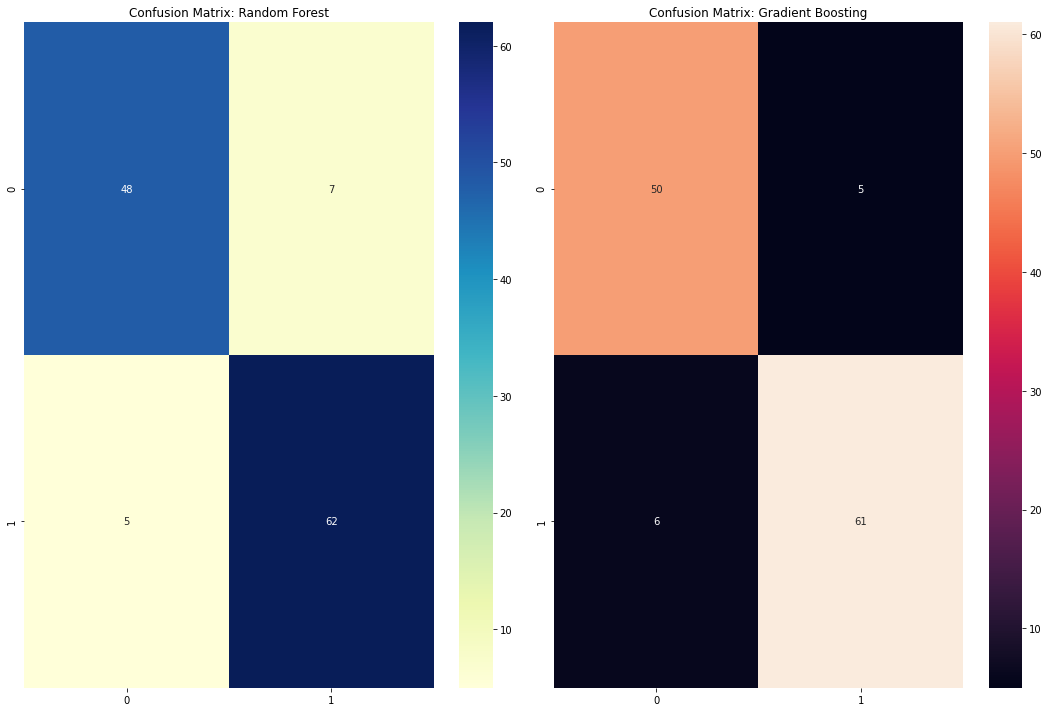

In [18]:
# Output confusion matrices for the random forest and gradient boosting baseline models
import seaborn as sns

confusion_rf = confusion_matrix(y_test, y_pred_rfc)
confusion_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
sns.heatmap(confusion_rf, annot = True, cmap="YlGnBu")
plt.title("Confusion Matrix: Random Forest")

plt.subplot(1,2,2)
sns.heatmap(confusion_gb, annot = True)
plt.title("Confusion Matrix: Gradient Boosting")

plt.tight_layout()
plt.show()

Based upon the above confusion matrices, the two methods are fairly similar, however, the random forest classifier does possess fewer false negative classifications than the gradient boosting classifier. Hence, we will proceed with the former method for our model and tune its hyperparameters. 